In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Load dataset
data = pd.read_csv('dataset.csv')

In [3]:
# Rename columns
data.rename(columns={'Unnamed: 0': 'id', 'Title': 'name', 'Ingredients': 'ingredients',
                     'Instructions': 'steps', 'Image_Name': 'image'}, inplace=True)

In [4]:
# Pilih kolom yang relevan
new_data = data[['id', 'name', 'ingredients', 'steps', 'image']]

In [5]:
# Tambahkan kolom rating dengan nilai random antara 1-5
new_data['rating'] = [random.randint(1, 5) for _ in range(len(new_data))]

In [6]:
# Tambahkan kolom cluster dengan nilai random 0 atau 1
new_data['cluster'] = np.random.choice([0, 1], size=len(new_data), replace=True)
new_data['cluster_label'] = new_data['cluster'].map({0: 'biasa saja', 1: 'favorit'})

In [7]:
# **Gunakan TF-IDF yang lebih optimal**
tfidf = TfidfVectorizer(stop_words='english', max_features=15000, ngram_range=(1, 2))
X_ingredients = tfidf.fit_transform(new_data['ingredients'].values.astype('U'))

In [8]:
# **Optimasi jumlah cluster menggunakan Elbow Method**
wcss = []
for i in range(2, 10):  # Uji cluster dari 2 hingga 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_ingredients)
    wcss.append(kmeans.inertia_)

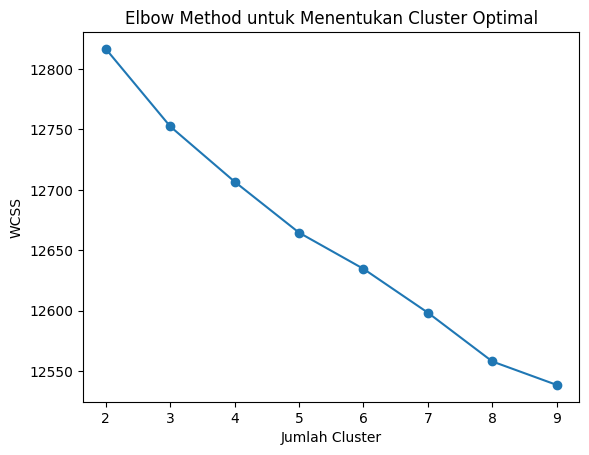

In [9]:
# Plot Elbow Method untuk menentukan jumlah cluster terbaik
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS")
plt.title("Elbow Method untuk Menentukan Cluster Optimal")
plt.show()


In [10]:
# **Gunakan K-Means dengan cluster optimal**
optimal_clusters = 7  # Tentukan jumlah berdasarkan hasil elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
new_data['category_num'] = kmeans.fit_predict(X_ingredients)

In [11]:
# **Pemetaan kategori yang lebih presisi**
category_mapping = {
    0: "Meat-Based",
    1: "Vegetarian",
    2: "Dessert",
    3: "Bakery",
    4: "Italian",
    5: "Seafood",
    6: "Healthy"
}

In [12]:
new_data['category'] = new_data['category_num'].map(category_mapping)

In [13]:
# **Gunakan Naïve Bayes dengan smoothing alpha**
model_category = MultinomialNB(alpha=0.1)
model_category.fit(X_ingredients, new_data['category_num'])

MultinomialNB(alpha=0.1)

In [14]:
# **Gunakan TF-IDF lebih optimal untuk rekomendasi berdasarkan nama**
cv = TfidfVectorizer(max_features=15000, stop_words='english', ngram_range=(1, 2))
X_name = cv.fit_transform(new_data['name'].values.astype('U'))

In [15]:
model_recommendation = MultinomialNB(alpha=0.1)
y = np.arange(len(new_data))
model_recommendation.fit(X_name, y)

MultinomialNB(alpha=0.1)

In [16]:
# **Fungsi untuk mencari berdasarkan nama kategori dengan hasil acak**
def search_by_category(category_name, N=5):
    matching_items = new_data[new_data['category'] == category_name]
    if matching_items.empty:
        print(f"Tidak ditemukan makanan dalam kategori '{category_name}'")
    else:
        print(f"Makanan acak dalam kategori '{category_name}':")
        print(matching_items.sample(frac=1).head(N)[['id', 'name', 'ingredients', 'category', 'rating', 'cluster_label']])

In [17]:
# **Fungsi untuk mencari berdasarkan cluster dengan hasil acak**
def search_by_cluster(cluster_label, N=5):
    matching_items = new_data[new_data['cluster_label'] == cluster_label]
    if matching_items.empty:
        print(f"Tidak ditemukan makanan dalam cluster '{cluster_label}'")
    else:
        print(f"Makanan acak dalam cluster '{cluster_label}':")
        print(matching_items.sample(frac=1).head(N)[['id', 'name', 'ingredients', 'category', 'rating', 'cluster_label']])

In [18]:
# **Fungsi untuk mencari berdasarkan nama dan memberikan 5 rekomendasi**
def recommend_nb(name):
    query_vec = cv.transform([name.lower()])
    predicted_probs = model_recommendation.predict_proba(query_vec)[0]
    top_5_indices = np.argsort(predicted_probs)[-5:][::-1]

    recommended_items = new_data.iloc[top_5_indices].copy()
    recommended_items['predicted_category'] = recommended_items['ingredients'].apply(
        lambda x: category_mapping.get(model_category.predict(tfidf.transform([x.lower()]))[0], "Unknown")
    )

    print("Rekomendasi untuk:", name)
    print(recommended_items[['id', 'name', 'ingredients', 'category', 'predicted_category', 'rating', 'cluster_label']])

In [24]:
# **Tes pencarian berdasarkan kategori (acak)**
search_by_category("Dessert")

Makanan acak dalam kategori 'Dessert':
          id                                               name  \
4366    4366                       Noodle-less Zucchini Lasagna   
2234    2234                    Slow-Cooker Green Chicken Chili   
10731  10731                Roasted Garlic-Balsamic Steak Sauce   
9420    9420  Eel With Olives, Chiles, and Capers (Anguilla ...   
3649    3649  Orzo with Beets, Olives, Feta, and Soft-Boiled...   

                                             ingredients category  rating  \
4366   ['1 pound 93% lean ground beef', '1 1/4 teaspo...  Dessert       1   
2234   ['3 pounds boneless, skinless chicken thighs',...  Dessert       3   
10731  ['1 1/2 cups warm water', '3/4 cup raisins', '...  Dessert       1   
9420   ['2 cups basic tomato sauce', '1 cup dry red w...  Dessert       1   
3649   ['2 medium golden beets, peeled, cut into 1/8"...  Dessert       3   

      cluster_label  
4366        favorit  
2234        favorit  
10731       favorit  
9420   

In [20]:
# **Tes pencarian berdasarkan cluster (acak)**
search_by_cluster("favorit")

Makanan acak dalam cluster 'favorit':
        id                                               name  \
4112  4112  Mozzarella-Stuffed Pork Chops with Polenta and...   
2069  2069  Potato, Leek, and Pea Pot Pie with Spinach-Aru...   
5785  5785                   Apple Fritters with Orange Glaze   
6138  6138                              Lemon-Pepper Salt Rub   
3347  3347            Sour Cream Mashed Potatoes With Paprika   

                                            ingredients    category  rating  \
4112  ['1 cup quick-cooking polenta', '4 (1-inch) th...     Dessert       1   
2069  ['1 medium leek, white and light-green parts o...     Healthy       1   
5785  ['2 cups all-purpose flour', '1/2 cup sugar', ...  Vegetarian       4   
6138  ['2 tablespoons whole black peppercorns', '3 t...     Dessert       1   
3347  ['5 pounds Yukon Gold potatoes, peeled, cut in...     Dessert       2   

     cluster_label  
4112       favorit  
2069       favorit  
5785       favorit  
6138       f

In [25]:
# **Tes pencarian berdasarkan nama makanan**
target_item = "BURGER"
recommend_nb(target_item)

Rekomendasi untuk: BURGER
        id                       name  \
7020  7020              Pete's Burger   
9656  9656              Aussie Burger   
6956  6956        The Trifecta Burger   
5509  5509  The Burger Lover's Burger   
9144  9144       Bean & 'Bello Burger   

                                            ingredients category  \
7020  ['4 slices aged Cheddar cheese', '1 onion, cut...  Healthy   
9656  ['1/4 cup ketchup', '1/4 cup mayonnaise', '1 t...  Seafood   
6956  ['1 cup (96 g) TVP granules', '1 cup (235 ml) ...  Seafood   
5509  ['1 1/2 pounds well-marbled beef chuck top bla...  Dessert   
9144  ['4 tablespoons canola oil', '2 medium portobe...  Dessert   

     predicted_category  rating cluster_label  
7020            Dessert       2    biasa saja  
9656            Seafood       4    biasa saja  
6956            Seafood       2       favorit  
5509            Dessert       4    biasa saja  
9144            Dessert       3       favorit  


In [26]:
accuracy_category = model_category.score(X_ingredients, new_data['category_num'])
print(f"Akurasi Model Kategori Naïve Bayes: {accuracy_category:.2%}")


Akurasi Model Kategori Naïve Bayes: 87.53%


In [27]:
accuracy_recommendation = model_recommendation.score(X_name, y)
print(f"Akurasi Model Rekomendasi Nama: {accuracy_recommendation:.2%}")


Akurasi Model Rekomendasi Nama: 97.08%


In [28]:
print(new_data['category'].value_counts())


category
Seafood       3743
Dessert       3131
Healthy       2692
Bakery        1217
Vegetarian    1017
Italian        891
Meat-Based     810
Name: count, dtype: int64


In [29]:
recommend_nb("Pizza")
recommend_nb("Cake")
recommend_nb("Smoothie")
recommend_nb("Burger")


Rekomendasi untuk: Pizza
          id                    name  \
1420    1420             Salad Pizza   
11046  11046         Chocolate Pizza   
13023  13023           Apple "Pizza"   
8504    8504      "Pizza" Sandwiches   
5667    5667  Veggi-Prosciutto Pizza   

                                             ingredients category  \
1420   ['1 pound store-bought pizza dough,room temper...  Dessert   
11046  ['Pizza dough', '2 tablespoons butter (1/4 sti...   Bakery   
13023  ['1 frozen puff pastry sheet (from a 17 1/4-oz...  Seafood   
8504   ['4 tablespoons extra-virgin olive oil plus ad...  Dessert   
5667   ['1 package (16 ounces) frozen whole-wheat piz...  Seafood   

      predicted_category  rating cluster_label  
1420             Dessert       1    biasa saja  
11046             Bakery       1       favorit  
13023            Seafood       2       favorit  
8504             Dessert       3    biasa saja  
5667             Dessert       1    biasa saja  
Rekomendasi untuk: Cake
 